In [1]:
#Necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from math import sqrt
import datetime 
import calendar
import sys

In [2]:
# Load the data from the Excel file
file_path = r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\Dairy\Merged_data.xlsx'
df = pd.read_excel(file_path, header=0 )

#df.index = df['Date']

In [3]:
# Define the function to create seasonal dummy variables
def SeasonalDummies(df, frequency='M'):
    nT = len(df)  # Number of observations
    startdate = df.index[0]  # Start date of the time series
    datetime = pd.DataFrame(data=pd.date_range(startdate, periods=nT, freq=frequency), columns=["datetime"])
    monthnumber = datetime["datetime"].dt.month  # Extract month numbers
    monthname = pd.DataFrame()  # DataFrame to store month names
    
    for i in range(nT):
        monthname.at[i, 'D'] = calendar.month_name[monthnumber[i]]  # Assign month names based on month numbers
    
    seasdum = pd.get_dummies(monthname)  # Create dummy variables for each month
    seasdum = seasdum.drop('D_January', axis=1)  # Drop January to avoid multicollinearity
    seasdum = seasdum.set_index(df.index)  # Set the index to match the original DataFrame
    seasdum = seasdum.astype(int)
    return seasdum

# Create seasonal dummies
seasdum = SeasonalDummies(df)

# Combine the data with the seasonal dummy variables
df = pd.concat([df, seasdum], axis=1)


In [ ]:
#lag length selection
from statsmodels.tsa.api import VAR
selected_data = df[['API', 'PPI', 'CPI']]
#selected_data = df[['API', 'PPI', 'CPI',  'Dairy_Conce'  'CWage_20', 'Oil']]

#model fitting 
model = VAR(selected_data)

#optimal lag length 
lag_order = model.select_order(maxlags=12)  

print(lag_order.summary())

In [17]:
# Extract the endogenous variables
endog = model.endog

# Create a DataFrame with variable names
df = pd.DataFrame(endog, columns=model.endog_names)

# Calculate the correlation matrix
corr_matrix = df.corr()

# Print the correlation matrix with variable names
print(corr_matrix)


                  Oil  Silage_PI  Dairy_Conce  CWage_20       API       PPI  \
Oil          1.000000   0.047129     0.263937 -0.232156  0.436070  0.095929   
Silage_PI    0.047129   1.000000     0.844521  0.841824  0.543728  0.900476   
Dairy_Conce  0.263937   0.844521     1.000000  0.807703  0.715143  0.865681   
CWage_20    -0.232156   0.841824     0.807703  1.000000  0.415133  0.839613   
API          0.436070   0.543728     0.715143  0.415133  1.000000  0.581181   
PPI          0.095929   0.900476     0.865681  0.839613  0.581181  1.000000   
CPI         -0.116569   0.887612     0.848419  0.948429  0.533604  0.937244   

                  CPI  
Oil         -0.116569  
Silage_PI    0.887612  
Dairy_Conce  0.848419  
CWage_20     0.948429  
API          0.533604  
PPI          0.937244  
CPI          1.000000  


In [4]:
#Create a break dummy associated with the Russia-Ukraine conflict
break_date = '2021-09-01'
df['break_dummy'] = (df['Date']>= break_date).astype(int)

#create a trend variable
df['trend'] = range(1, len(df) + 1)  

#Create differenced exogenous lags
columns = ['Oil',  'Silage_PI', 'Dairy_Conce', 'CWage_20', 'break_dummy', 'API', 'PPI','CPI']

for column in columns:
    df[f'd_{column}'] = df[column].diff()

In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM
import re

df.dropna(inplace = True)

#Define endogenous and exogenous variables
X = df[[ 'd_Oil',  'd_Dairy_Conce', 'd_CWage_20', 'break_dummy', 'D_April', 'D_August', 'D_December', 
        'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']] # Exogenous

Y = df[['API', 'PPI','CPI']] # Endog

exog_names = ['d_Oil', 'd_Dairy_Conce', 'd_CWage_20', 'break_dummy', 
             'D_April', 'D_August', 'D_December', 
              'D_February', 'D_July', 'D_June', 'D_March', 'D_May', 'D_September', 
              'D_October', 'D_November']

def rename_exog_variables(summary_text, exog_names):
    # Creating a mapping from 'exogX' to actual variable names
    exog_map = {f'exog{i+1}': name for i, name in enumerate(exog_names)}

    # Replace the exogX in the summary text with the actual names
    for exog, name in exog_map.items():
        summary_text = re.sub(r'\b{}\b'.format(exog), name, summary_text)
    
    return summary_text

# VECM model
vecm = VECM(endog=Y, exog=X, k_ar_diff=4, coint_rank=1)  
vecm_fit = vecm.fit()

# model summary
summary_str = vecm_fit.summary().as_text()

# Rename exog variables
renamed_summary = rename_exog_variables(summary_str, exog_names)

# Print summary
print(renamed_summary)

Length of Y: 159
Length of fittedvalues: 159


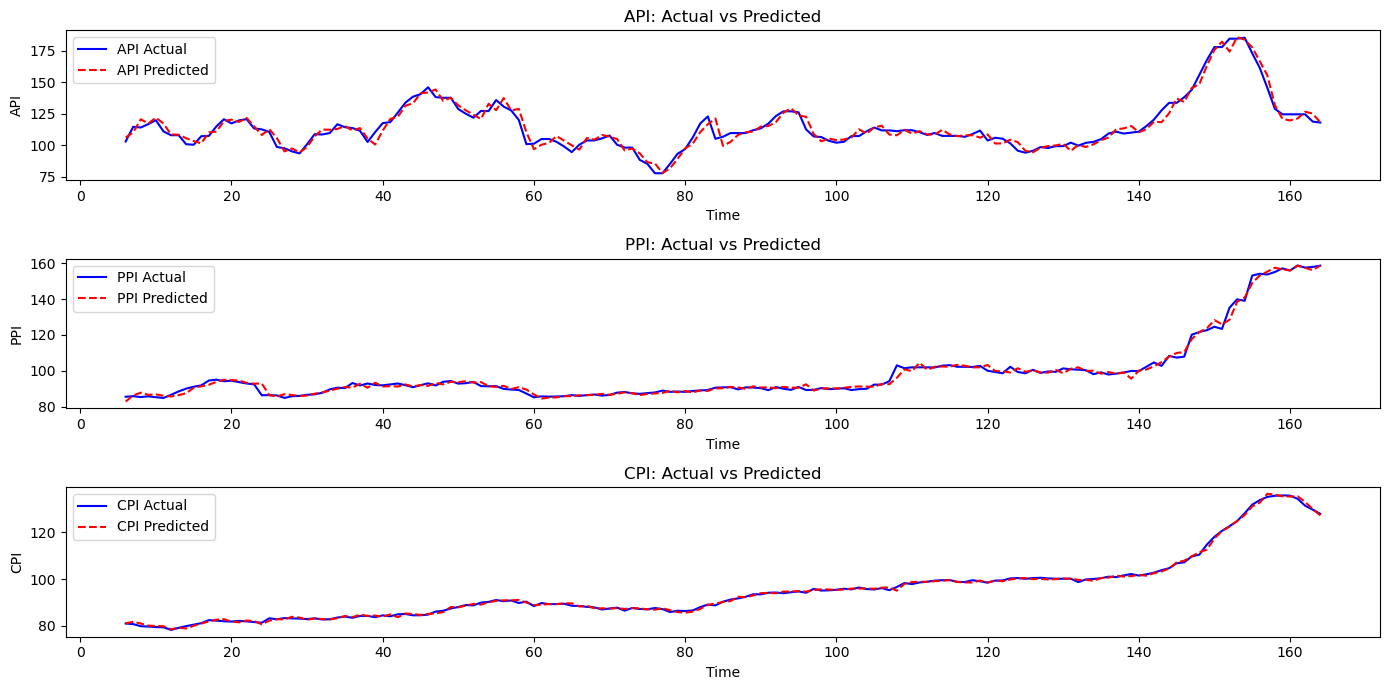

In [8]:
# Getting and plotting the predicted values
# removing the first 5 observations lost in lags and differencing
adjusted_Y = Y.iloc[5:] 

# Checking the lengths of Y2 and fitted values for consistency
print(f"Length of Y: {len(adjusted_Y)}")
print(f"Length of fittedvalues: {len(vecm_fit.fittedvalues)}")

predicted_df = pd.DataFrame(vecm_fit.fittedvalues, columns=adjusted_Y .columns)
predicted_df.index = adjusted_Y.index # Align the index with the actual data for comparison

# Combining actual and predicted values and renaming the columns
comparison_df = pd.concat([adjusted_Y, predicted_df], axis=1)
comparison_df.columns = ['API_Actual','PPI_Actual', 'CPI_Actual', 'API_Predicted', 'PPI_Predicted', 'CPI_Predicted']

import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot for API
plt.subplot(3, 1, 1)
plt.plot(comparison_df.index, comparison_df['API_Actual'], label='API Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['API_Predicted'], label='API Predicted', color='red', linestyle='--')
plt.title('API: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('API')
plt.legend()

# Plot for PPI
plt.subplot(3, 1, 2)
plt.plot(comparison_df.index, comparison_df['PPI_Actual'], label='PPI Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['PPI_Predicted'], label='PPI Predicted', color='red', linestyle='--')
plt.title('PPI: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('PPI')
plt.legend()

# Plot for CPI
plt.subplot(3, 1, 3)
plt.plot(comparison_df.index, comparison_df['CPI_Actual'], label='CPI Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['CPI_Predicted'], label='CPI Predicted', color='red', linestyle='--')
plt.title('CPI: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()

plt.savefig('Fitted_Plots.png')
plt.tight_layout()
plt.show()



In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#  Ljung-Box test for autocorrelation
for i in range(vecm_fit.resid.shape[1]):
    print(f"Ljung-Box Test for Residuals of Equation {i+1}:")
    ljung_box_results = acorr_ljungbox(vecm_fit.resid[:, i], lags=[1, 5, 8])
    print(ljung_box_results)
    print("\n")

In [40]:
from statsmodels.stats.diagnostic import het_arch

# ARCH test for heteroscedasticity for each equation
arch_test_results = [het_arch(resid) for resid in vecm_fit.resid.T]

# DataFrame to store the results
columns = ['Test Statistic', 'P-value', 'Lags used']
results_df = pd.DataFrame(columns=columns)

# DataFrame with the results
for i, result in enumerate(arch_test_results):
    test_statistic, p_value, lags_used, _ = result
    results_df.loc[f'Equation {i+1}'] = [test_statistic, p_value, lags_used]

# Display the results
print(results_df)

            Test Statistic   P-value  Lags used
Equation 1       14.389373  0.155960   1.475168
Equation 2        5.371211  0.865043   0.516071
Equation 3       10.775145  0.375303   1.075762


In [ ]:
#Differenced VAR model for model comparison
df.dropna(inplace = True)

#Define endog and exog variables
X2 = df[[ 'd_Oil', 'd_Dairy_Conce', 'd_CWage_20', 'd_break_dummy', 'D_April', 'D_August', 'D_December', 'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']] 
#X = sm.add_constant(X)
Y2 = df[['d_API', 'd_PPI','d_CPI']] 

# Fit the VAR model
var = VAR(Y2, X2)  
var_fit = var.fit(4)

# Print the modified summary
print(var_fit.summary())

In [ ]:
import matplotlib.pyplot as plt

# Generating impulse response functions
irf = vecm_fit.irf(periods=12)

# with confidence intervals
fig = plt.figure(figsize=(14, 12))
irf.plot(orth=True, plot_stderr=True)  # CI

plt.suptitle('Impulse Response Functions', fontsize=18, fontweight='bold')

# Customizing each subplot in the figure
for ax in plt.gcf().axes:
    ax.set_xlabel('Periods', fontsize=14)
    ax.set_ylabel('Response', fontsize=14)
    ax.grid(True) 
    ax.xaxis.set_tick_params(labelsize=12) 
    ax.yaxis.set_tick_params(labelsize=12)

# Adjust layout to remove overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show the plot
plt.savefig('improved_irf_plot.png', bbox_inches='tight') 
plt.show()


In [ ]:
# Granger Causality Test Function
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_test(df, var1, var2, max_lag):
    print(f'Granger Causality Test: {var1} causes {var2}')
    test_result = grangercausalitytests(df[[var2, var1]], max_lag, verbose=True)
    return test_result

# Usage
max_lag = 4

#On CPI
granger_causality_test(df, 'PPI', 'CPI', max_lag)
granger_causality_test(df, 'API', 'CPI', max_lag)
granger_causality_test(df, 'Oil', 'CPI', max_lag)
granger_causality_test(df, 'Silage_PI', 'CPI', max_lag)
granger_causality_test(df, 'Dairy_Conce', 'CPI', max_lag)
granger_causality_test(df, 'CWage_20', 'CPI', max_lag)

In [ ]:
#On PPI
granger_causality_test(df, 'CPI', 'PPI', max_lag)
granger_causality_test(df, 'API', 'PPI', max_lag)
granger_causality_test(df, 'Oil', 'PPI', max_lag)
granger_causality_test(df, 'Silage_PI', 'PPI', max_lag)
granger_causality_test(df, 'Dairy_Conce', 'PPI', max_lag)
granger_causality_test(df, 'CWage_20', 'PPI', max_lag)

In [ ]:
#On API
granger_causality_test(df, 'CPI', 'API', max_lag)
granger_causality_test(df, 'PPI', 'API', max_lag)
granger_causality_test(df, 'Oil', 'API', max_lag)
granger_causality_test(df, 'Silage_PI', 'API', max_lag)
granger_causality_test(df, 'Dairy_Conce', 'API', max_lag)
granger_causality_test(df, 'CWage_20', 'API', max_lag)

In [ ]:
# Factor Error Variance Decomposition
from statsmodels.tsa.api import VAR

var_model = VAR(vecm_fit.model.endog)
#var_fit = var_model.fit(maxlags=vecm_fit.k_ar_diff)

n_lags = vecm_fit.k_ar

var_fit = var_model.fit(maxlags=n_lags)

# variance decomposition
fevd = var_fit.fevd(periods=12)

#  results
print(fevd.summary())
